In [1]:
import networkx as nx  
import shapely.geometry
import pyproj


import datetime as dt
import time
import simpy
import openclsim
import opentnsim

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import folium

In [2]:
# setup environment
simulation_start = 0
my_env = simpy.Environment(initial_time=simulation_start)

In [3]:
Site = type('Site',
            (openclsim.core.Identifiable,
             openclsim.core.Log,
             openclsim.core.Locatable,
             openclsim.core.HasContainer,
             openclsim.core.HasResource,), {})

Waypoint = type('Way',
            (openclsim.core.Identifiable,
             openclsim.core.Log,
             openclsim.core.Locatable,), {})

# create a TransportProcessingResource  object based on desired mixin classes
TransportProcessingResource = type(
    "TransportProcessingResource",
    (
        openclsim.core.ContainerDependentMovable,      # add opentnsim Movable to allow sailing on graph
        openclsim.core.HasResource,
        openclsim.core.HasContainer,
        openclsim.core.Processor,
        openclsim.core.Identifiable,
        openclsim.core.Log,
        openclsim.core.LoadingFunction,
        openclsim.core.UnloadingFunction,
        # capture extra metadata to make sure we don't have leftover arguments
        opentnsim.core.ExtraMetadata
    ),
    {},
)

In [4]:
locations = []

location_offshore = shapely.geometry.Point(3.637610458072877, 52.10701582514347)
data_offshore = {"env": my_env,
                 "name": "offshore",
                 "geometry": location_offshore,
                 "capacity": 100,
                 "level": 0,
                }
offshore = Site(**data_offshore)

location_offshore_waypoint = shapely.geometry.Point(3.86736205092947,52.02761645094746)
data_offshore_waypoint = {"env": my_env,
                 "name": "offshore_waypoint",
                 "geometry": location_offshore_waypoint,
                }
offshore_waypoint = Waypoint(**data_offshore_waypoint)

location_berth = shapely.geometry.Point(4.062705498083785,51.95909715255291)
data_berth = {"env": my_env,
              "name": "berth",
              "geometry": location_berth,
              "capacity": 100,
              "level": 80,
              "nr_resources": 1
             }
berth = Site(**data_berth)

location_dredging_waypoint = shapely.geometry.Point(4.051396629618069,52.02445392693116)
data_dredging_waypoint = {"env": my_env,
                 "name": "dredging_waypoint",
                 "geometry": location_dredging_waypoint,
                }
dredging_waypoint = Waypoint(**data_dredging_waypoint)

location_dump = shapely.geometry.Point(4.1795229742823,52.11590591837503)
data_dump = {"env": my_env,
             "name": "dump",
             "geometry": location_dump,
             "capacity": 100,
             "level": 0
            }
dump = Site(**data_dump) 

In [5]:
path = [
    [offshore, offshore_waypoint],
    [offshore_waypoint, berth],
    [dump, dredging_waypoint],
    [dredging_waypoint, berth]]

In [6]:
# three locations (offshore, berth, and dump) are defined to allow the vessels pass the nodes back and forth.
# based on the mixins, more attributes are defined for each location.
locations = []
locations.append(offshore)
locations.append(offshore_waypoint)
locations.append(berth)
locations.append(dredging_waypoint)
locations.append(dump)

Number of edges is 8


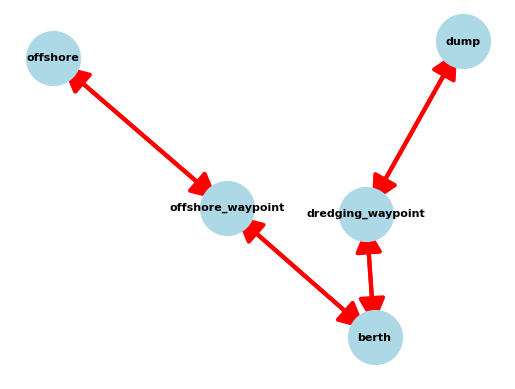

In [7]:
# we start with creating a graph 
graph = nx.DiGraph()

# a graph is initiated based on the name and gemometry of locations.
# other attributes such as store_capacity and initials are not being used for drawing the graph.
for location in locations:
    graph.add_node(location.name,
                geometry = location.geometry)
     
# add edges
for index, edge in enumerate(path):
    graph.add_edge(edge[0].name, edge[1].name, weight = 1)
    
# toggle to undirected and back to directed to make sure all edges are two way traffic
graph = graph.to_undirected() 
graph = graph.to_directed()

# create a positions dict for the purpose of plotting
positions = {}
for location in graph.nodes:
    positions[location] = (graph.nodes[location]['geometry'].x, graph.nodes[location]['geometry'].y)
    
# collect node labels.
labels = {}
for location in graph.nodes:
    labels[location] = location
print('Number of edges is {}'.format(len(graph.edges)))

# draw edges, nodes and labels.
nx.draw_networkx_edges(graph,  pos=positions, width=3, edge_color="red", alpha=1, arrowsize=40)
nx.draw_networkx_nodes(graph,  pos=positions, node_color="lightblue", node_size=1500)
nx.draw_networkx_labels(graph, pos=positions, labels=labels, font_size=8, font_weight='bold', font_color="black")

plt.axis("off")
plt.show()

In [8]:
my_env.graph = graph

In [9]:
path1 = nx.dijkstra_path(my_env.graph, 'offshore', 'berth')
path2 = nx.dijkstra_path(my_env.graph, 'berth', 'offshore')
path_seagoing = path1+path2[1:]
display(path_seagoing)

path3 = nx.dijkstra_path(my_env.graph, 'dump', 'berth')
path4 = nx.dijkstra_path(my_env.graph, 'berth', 'dump')
path_dredging = path3+path4[1:]
display(path_dredging)

['offshore', 'offshore_waypoint', 'berth', 'offshore_waypoint', 'offshore']

['dump', 'dredging_waypoint', 'berth', 'dredging_waypoint', 'dump']

In [10]:
start_location = "dump"
data_vessel01 = {
    "env": my_env,
    "name": "dredging vessel",
    "geometry": locations[[i for i, x in enumerate(locations) if x.name == start_location][0]].geometry, 
    "capacity": 10,
    "loading_rate": 1,
    "unloading_rate": 0.5,
    "compute_v": lambda x: 10 + 2 * x,
}
# instantiate vessel_01 
vessel01 = TransportProcessingResource(**data_vessel01)
# assert not vessel01.metadata

In [11]:
# prepare input data for vessel_02
start_location = "offshore"
data_vessel02 = {
    "env": my_env,
    "name": "seagoing vessel",
    "geometry": locations[[i for i, x in enumerate(locations) if x.name == start_location][0]].geometry, 
    "capacity": 10,
    "level": 5,
    "loading_rate": 1,
    "unloading_rate": 0.5,
    "compute_v": lambda x: 10 + 2 * x}
    
vessel02 = TransportProcessingResource(**data_vessel02)
assert not vessel02.metadata

In [12]:
registry = {}

In [13]:
amount = 10
duration = 200
requested_resources={}

a = [
    openclsim.model.MoveActivity(
        env=my_env,
        name="sailing empty dredging vessel",
        registry=registry,
        mover=vessel01,
        destination=berth,
        duration=duration,
        ),
    openclsim.model.ShiftAmountActivity(
        env=my_env,
        name="loading dredging vessel",
        registry=registry,
        processor=vessel01,
        origin=berth,
        destination=vessel01,
        amount=amount,
        duration=50*amount,
        requested_resources=requested_resources,
        ),
    openclsim.model.MoveActivity(
        env=my_env,
        name="sailing full dredging vessel",
        registry=registry,
        mover=vessel01,
        destination=dump,
        duration=duration,
        ),
    openclsim.model.ShiftAmountActivity(
        env=my_env,
        name="unloading dredging vessel",
        registry=registry,
        processor=vessel01,
        origin=vessel01,
        destination=dump,
        amount=amount,
        duration=20*amount,
        requested_resources=requested_resources,
        )
]

activities_dredging_vessel = openclsim.model.WhileActivity(
            env=my_env,
            name="while sequential activity dredging vessel",
            registry=registry,
            sub_processes=[openclsim.model.SequentialActivity(
                env=my_env,
                name=f"sequential activity subcycle dredging vessel",
                registry=registry,
                sub_processes= a
            )],
             condition_event=[{"type": "container",
                              "concept": berth,
                              "state": "empty",
                              "id_":"default_reservations"}
                             ]
        )

requested_resources_b = {}
b = [
    openclsim.model.BasicActivity(
        env=my_env,
        name="interval time",
        registry=registry,
        duration=200
        ),
    openclsim.model.MoveActivity(
        env=my_env,
        name="sailing full seagoing vessel",
        registry=registry,
        mover=vessel02,
        destination=berth,
        duration=duration,
        ),
    openclsim.model.ShiftAmountActivity(
        env=my_env,
        name="unloading seagoing vessel",
        registry=registry,
        processor=vessel02,
        origin=vessel02,
        destination=berth,
        amount=amount,
        duration=30*amount,
        requested_resources=requested_resources_b,
        ),
    openclsim.model.MoveActivity(
        env=my_env,
        name="sailing empty seagoing vessel",
        registry=registry,
        mover=vessel02,
        destination=offshore,
        duration=duration,
        )
]
activities_seagoing_vessel = openclsim.model.WhileActivity(
            env=my_env,
            name="while sequential activity dredging vessel",
            registry=registry,
            sub_processes= b,
            condition_event=[{"type": "container",
                              "concept": vessel02,
                              "state": "empty",
                              "id_":"default_reservations",
                              }
                             ]
        )



In [14]:
openclsim.model.register_processes([activities_dredging_vessel])
openclsim.model.register_processes([activities_seagoing_vessel])

In [15]:
my_env.run()

mover dredging vessel destination berth
updating to destination geometry POINT (4.062705498083785 51.95909715255291)
mover seagoing vessel destination berth
updating to destination geometry POINT (4.062705498083785 51.95909715255291)
mover dredging vessel destination dump
updating to destination geometry POINT (4.1795229742823 52.11590591837503)
mover seagoing vessel destination offshore
mover dredging vessel destination berth
updating to destination geometry POINT (3.637610458072877 52.10701582514347)
updating to destination geometry POINT (4.062705498083785 51.95909715255291)
mover dredging vessel destination dump
updating to destination geometry POINT (4.1795229742823 52.11590591837503)
mover dredging vessel destination berth
updating to destination geometry POINT (4.062705498083785 51.95909715255291)
mover dredging vessel destination dump
updating to destination geometry POINT (4.1795229742823 52.11590591837503)
mover dredging vessel destination berth
updating to destination geomet

In [16]:
display(openclsim.plot.get_log_dataframe(vessel02, [activities_seagoing_vessel]))

,Activity,Timestamp,ActivityState,geometry,container level
0,sailing full seagoing vessel,1970-01-01 00:03:20,START,POINT (3.637610458072877 52.10701582514347),5
1,sailing full seagoing vessel,1970-01-01 00:06:40,STOP,POINT (4.062705498083785 51.95909715255291),5
2,unloading seagoing vessel,1970-01-01 00:11:40,START,POINT (4.062705498083785 51.95909715255291),5
3,unloading seagoing vessel,1970-01-01 00:16:40,STOP,POINT (4.062705498083785 51.95909715255291),0
4,sailing empty seagoing vessel,1970-01-01 00:16:40,START,POINT (4.062705498083785 51.95909715255291),0
5,sailing empty seagoing vessel,1970-01-01 00:20:00,STOP,POINT (3.637610458072877 52.10701582514347),0


In [17]:
display(openclsim.plot.get_log_dataframe(vessel01, [activities_dredging_vessel]))

,Activity,Timestamp,ActivityState,geometry,container level
0,sailing empty dredging vessel,1970-01-01 00:00:00,START,POINT (4.1795229742823 52.11590591837503),0.0
1,sailing empty dredging vessel,1970-01-01 00:03:20,STOP,POINT (4.062705498083785 51.95909715255291),0.0
2,loading dredging vessel,1970-01-01 00:03:20,START,POINT (4.062705498083785 51.95909715255291),0.0
3,loading dredging vessel,1970-01-01 00:11:40,STOP,POINT (4.062705498083785 51.95909715255291),10.0
4,sailing full dredging vessel,1970-01-01 00:11:40,START,POINT (4.062705498083785 51.95909715255291),10.0
...,...,...,...,...,...
67,loading dredging vessel,1970-01-01 02:38:20,STOP,POINT (4.062705498083785 51.95909715255291),5.0
68,sailing full dredging vessel,1970-01-01 02:38:20,START,POINT (4.062705498083785 51.95909715255291),5.0
69,sailing full dredging vessel,1970-01-01 02:41:40,STOP,POINT (4.1795229742823 52.11590591837503),5.0
70,unloading dredging vessel,1970-01-01 02:41:40,START,POINT (4.1795229742823 52.11590591837503),5.0


In [18]:
openclsim.plot.get_gantt_chart([vessel01,vessel02], id_map=[activities_dredging_vessel, activities_seagoing_vessel])